In [1]:
%pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [1]:
%pip install pydot

Note: you may need to restart the kernel to use updated packages.


In [581]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [582]:
import pyarrow as pa
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from source import data_import

In [583]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler

In [584]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model

import keras 
from keras.models import Sequential # intitialize the ANN
from keras.layers import Dense, Activation, Dropout 

In [608]:
data = np.load('data/feature_extract_reshaped.npy')
data.shape

In [639]:
X=data[:,:,2:-1]
Y=data[:,:,-1]

In [640]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, stratify=Y, test_size = 0.2)

In [641]:
X_test.shape

(2666, 30, 60)

In [642]:
X_train.shape

(10664, 30, 60)

In [674]:
y_test=Y_test.max(axis=1)
y_train=Y_train.max(axis=1)
y_test.shape

(2666,)

In [675]:
shape=X_train.shape[1:]
shape

(30, 60)

In [658]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam

model = Sequential()

model.add(Input(shape=X_train.shape[1:]))

#model.add(normalizer)

# Recurrent layer
model.add(LSTM(64, return_sequences=False))

# Fully connected layer
model.add(Dense(64, activation='relu'))

# Dropout for regularization
model.add(Dropout(0.5))

model.add(BatchNormalization())

# Output layer
model.add(Dense(1, activation='sigmoid'))

# Compile the model
learning_rate = 0.001  # Replace with your desired learning rate

# Create an instance of the Adam optimizer with the specified learning rate
optimizer = Adam(learning_rate=learning_rate)
model.compile(
    optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [96]:
# from keras.callbacks import EarlyStopping, ModelCheckpoint

# # Create callbacks
# callbacks = EarlyStopping(monitor='val_loss', patience=5)

In [659]:
import numpy as np
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight

class_labels, class_counts = np.unique(y_test, return_counts=True)
total_samples = len(y_test)
class_weights = total_samples / (len(class_labels) * class_counts)

# Convert class weights to a dictionary
class_weight_dict = dict(zip(class_labels, class_weights))


In [598]:
class_weight_dict

{0.0: 0.581081081081081, 1.0: 3.5833333333333335}

In [660]:
## look at validation batch ?
history = model.fit(X_train,  y_train, 
                    batch_size=100, class_weight=class_weight_dict,
                    shuffle=True,
                    epochs=200,
                    validation_split = 0.2)

Epoch 1/200
86/86 [==============================] - 10s 39ms/step - loss: 0.7199 - accuracy: 0.5896 - val_loss: 0.6309 - val_accuracy: 0.7618
Epoch 2/200
86/86 [==============================] - 2s 24ms/step - loss: 0.5672 - accuracy: 0.7009 - val_loss: 0.4693 - val_accuracy: 0.8847
Epoch 3/200
86/86 [==============================] - 2s 26ms/step - loss: 0.4407 - accuracy: 0.7993 - val_loss: 0.3071 - val_accuracy: 0.9095
Epoch 4/200
86/86 [==============================] - 2s 23ms/step - loss: 0.3737 - accuracy: 0.8507 - val_loss: 0.3050 - val_accuracy: 0.9081
Epoch 5/200
86/86 [==============================] - 2s 27ms/step - loss: 0.2836 - accuracy: 0.8972 - val_loss: 0.1657 - val_accuracy: 0.9494
Epoch 6/200
86/86 [==============================] - 4s 43ms/step - loss: 0.2407 - accuracy: 0.9119 - val_loss: 0.1736 - val_accuracy: 0.9578
Epoch 7/200
86/86 [==============================] - 4s 42ms/step - loss: 0.1938 - accuracy: 0.9301 - val_loss: 0.2250 - val_accuracy: 0.8912
Epoch

In [568]:
def plot_accuracy(history):
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    #plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error ')
    plt.legend()
    plt.grid(True)

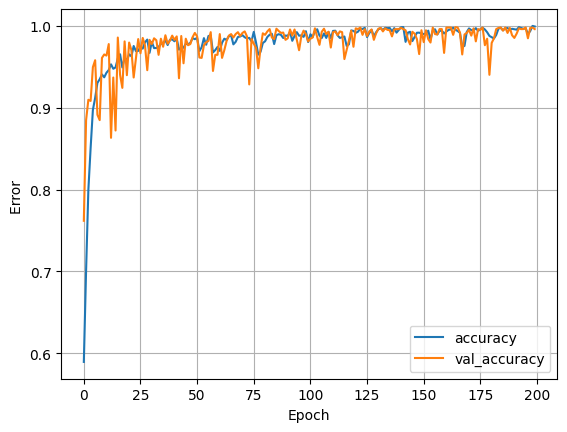

In [661]:
plot_accuracy(history)

In [443]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    #plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error ')
    plt.legend()
    plt.grid(True)

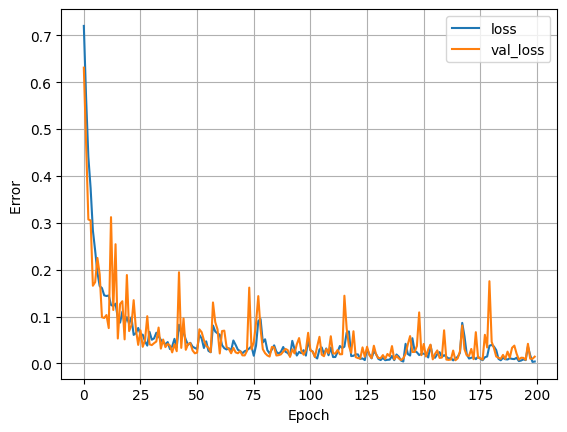

In [662]:
plot_loss(history)

In [517]:
model.evaluate(
    X_test,
    y_test, verbose=0)

[0.15189193189144135, 0.9396098852157593]

In [663]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f'Model accuracy: {accuracy}')

84/84 - 0s - loss: 0.0136 - accuracy: 0.9974 - 364ms/epoch - 4ms/step
Model accuracy: 0.9973743557929993


In [670]:
y_pred_train = model.predict(X_train)
y_pred_train

334/334 [==============================] - 2s 5ms/step


array([[3.1588101e-05],
       [9.9993217e-01],
       [1.6633399e-04],
       ...,
       [5.4462351e-05],
       [2.7257894e-07],
       [1.6577746e-06]], dtype=float32)

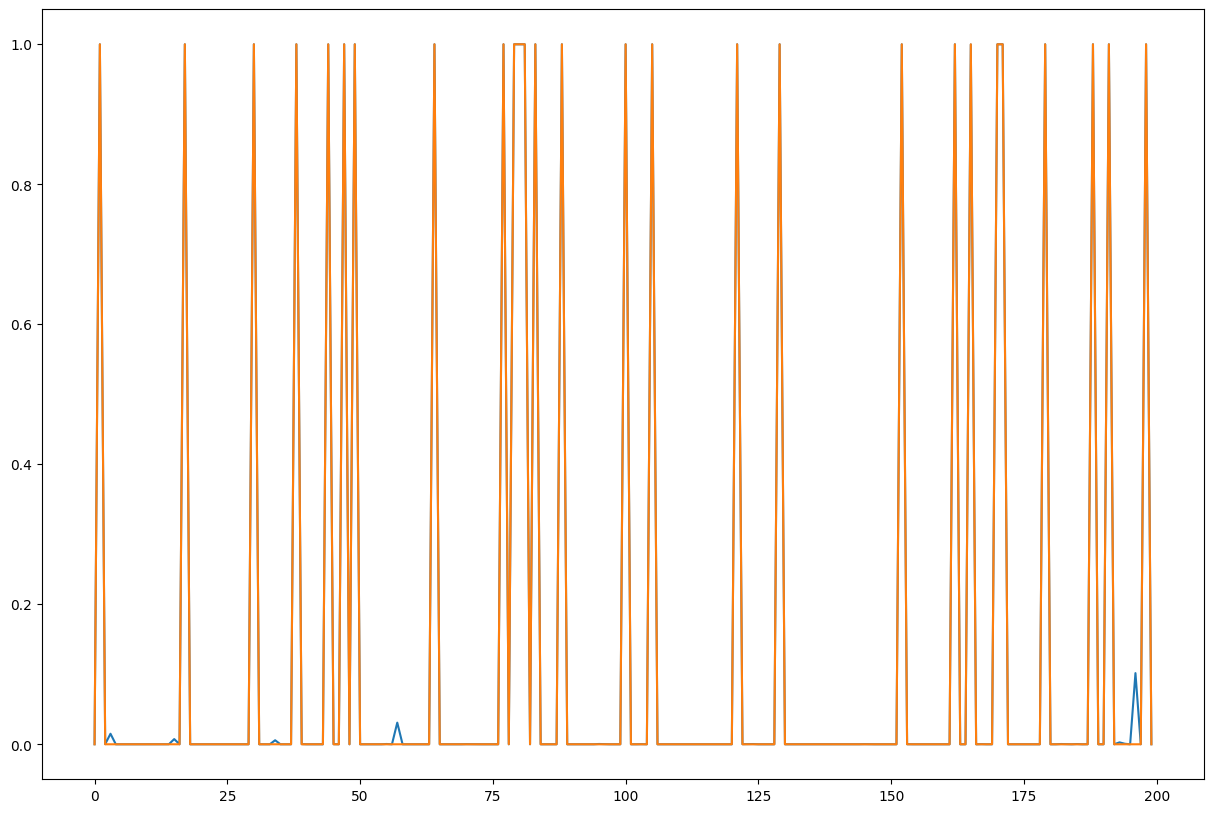

In [676]:
plt.figure(figsize=(15,10))  # Adjust the width and height as needed
plt.plot(y_pred_train[:200])
plt.plot(y_train[:200])


In [665]:
y_pred = model.predict(X_test)
y_pred

84/84 [==============================] - 1s 4ms/step


array([[1.8519951e-07],
       [9.9895614e-01],
       [1.4765926e-04],
       ...,
       [2.4934254e-06],
       [1.9719349e-07],
       [1.0000000e+00]], dtype=float32)

In [666]:
y_pred_c = y_pred.round().astype(int)
y_pred_c.shape

(2666, 1)

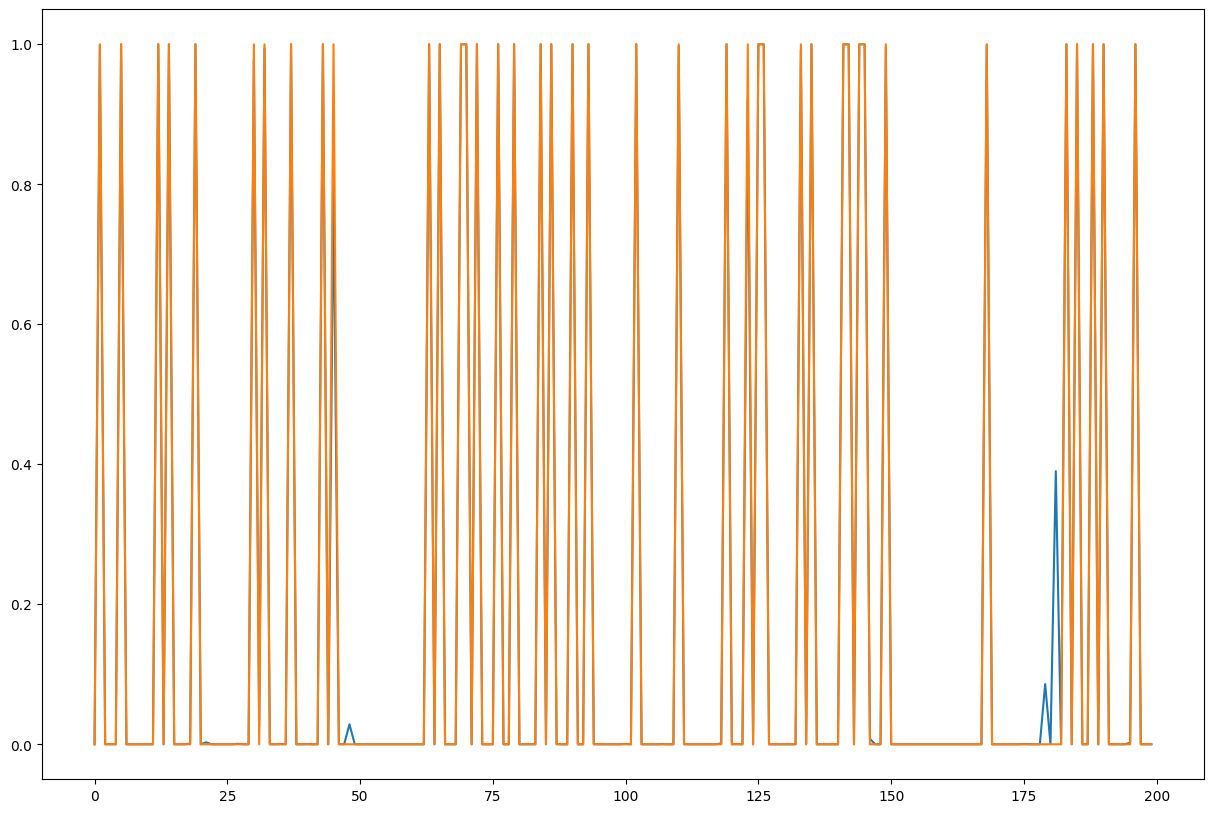

In [677]:
plt.figure(figsize=(15,10))  
plt.plot(y_pred[:200])
plt.plot(y_test[:200])

In [668]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix
y_pred_c = y_pred.round().astype(int)
precision = precision_score(y_test, y_pred_c)
recall = recall_score(y_test, y_pred_c)

loss, accuracy = model.evaluate(X_test, y_test)

print('Loss:', loss)
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
y_test.sum(), y_pred_c.sum()

84/84 [==============================] - 0s 5ms/step - loss: 0.0136 - accuracy: 0.9974
Loss: 0.013605944812297821
Accuracy: 0.9973743557929993
Precision: 0.9866666666666667
Recall: 0.9946236559139785


(372.0, 375)

In [634]:
sum(y_test==0)

2294

In [635]:
y_test.shape

(2666,)

In [636]:
sum(y_pred_c==1)

array([397])

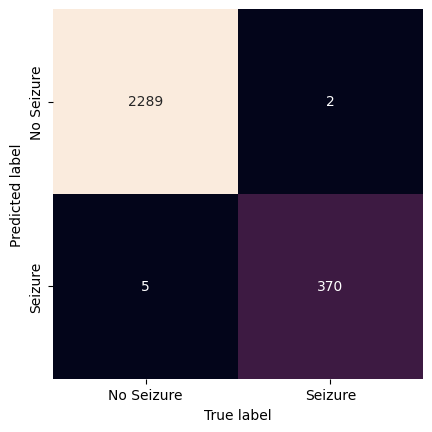

In [672]:
from sklearn.metrics import confusion_matrix, classification_report
mat = confusion_matrix(y_test, y_pred_c)
labels = ['No Seizure', 'Seizure']
# Create the heatmap with custom labels
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=labels, yticklabels=labels)

plt.xlabel('True label')
plt.ylabel('Predicted label')

plt.show()

In [673]:
report = classification_report(y_test, y_pred_c)
print("Classification Report:")
print(report)
 

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2294
         1.0       0.99      0.99      0.99       372

    accuracy                           1.00      2666
   macro avg       0.99      1.00      0.99      2666
weighted avg       1.00      1.00      1.00      2666



Text(0, 0.5, 'Predictions')

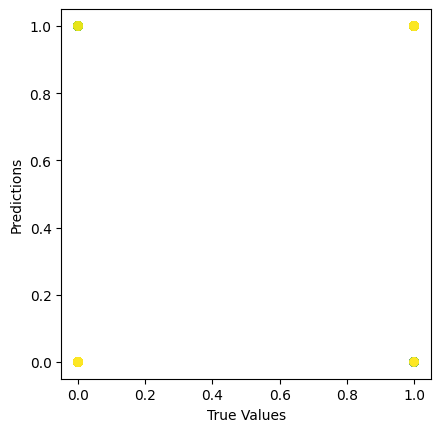

In [633]:
a = plt.axes(aspect='equal')
plt.scatter(y_test, y_pred_c,c=np.arange(len(y_test)))
plt.xlabel('True Values')
plt.ylabel('Predictions')
#lims = [0, 50]
#plt.xlim(lims)
#plt.ylim(lims)
#_ = plt.plot(lims, lims)

In [678]:
# error = y_pred_c - y_test
# plt.hist(error, bins=25)
# plt.xlabel('Prediction Error')
# _ = plt.ylabel('Count')

In [13]:
# def make_model(input_shape):
#     input_layer = keras.layers.Input(input_shape)

#     conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
#     conv1 = keras.layers.BatchNormalization()(conv1)
#     conv1 = keras.layers.ReLU()(conv1)

#     conv2 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
#     conv2 = keras.layers.BatchNormalization()(conv2)
#     conv2 = keras.layers.ReLU()(conv2)

#     conv3 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
#     conv3 = keras.layers.BatchNormalization()(conv3)
#     conv3 = keras.layers.ReLU()(conv3)

#     gap = keras.layers.GlobalAveragePooling1D()(conv3)

#     output_layer = keras.layers.Dense(num_classes, activation="softmax")(gap)

#     return keras.models.Model(inputs=input_layer, outputs=output_layer)


In [17]:
# model = make_model(input_shape=X_train.shape[1:])
# keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [268]:
# epochs = 500
# batch_size = 32

# callbacks = [
#     keras.callbacks.ModelCheckpoint(
#         "best_model.h5", save_best_only=True, monitor="val_loss"
#     ),
#     keras.callbacks.ReduceLROnPlateau(
#         monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
#     ),
#     keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
# ]
# model.compile(
#     optimizer="adam",
#     loss="sparse_categorical_crossentropy",
#     metrics=["sparse_categorical_accuracy"],
# )
# history = model.fit(
#     X_train,
#     y_train,
#     batch_size=batch_size,
#     epochs=epochs,
#     callbacks=callbacks,
#     #validation_split=0.2,
#     verbose=1,


inputs: A 3D tensor with shape [batch, timesteps, feature].

In [680]:
# Define a sequential model
model = keras.Sequential()

#model.add(normalizer)

# Add an input layer with an input shape of (time_steps, input_features)
model.add(layers.InputLayer(input_shape=(X_train.shape[1],X_train.shape[2])))

# Add a SimpleRNN layer with 32 units (neurons)
model.add(layers.SimpleRNN(32, activation='tanh'))

model.add(BatchNormalization())

# Add the output layer with 1 neuron and sigmoid activation for binary classification
model.add(layers.Dense(1, activation='sigmoid'))

# Compile the model with binary cross-entropy loss for binary classification
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [679]:
X_train.shape

(10664, 30, 60)

In [681]:
history = model.fit(X_train,  y_train, 
                    batch_size=100, epochs=200,
                    validation_split = 0.2)

Epoch 1/200
86/86 [==============================] - 8s 15ms/step - loss: 0.6237 - accuracy: 0.7139 - val_loss: 0.5036 - val_accuracy: 0.8251
Epoch 2/200
86/86 [==============================] - 1s 18ms/step - loss: 0.4524 - accuracy: 0.8432 - val_loss: 0.4159 - val_accuracy: 0.8448
Epoch 3/200
86/86 [==============================] - 1s 6ms/step - loss: 0.3878 - accuracy: 0.8610 - val_loss: 0.3883 - val_accuracy: 0.8551
Epoch 4/200
86/86 [==============================] - 1s 7ms/step - loss: 0.3578 - accuracy: 0.8631 - val_loss: 0.3646 - val_accuracy: 0.8523
Epoch 5/200
86/86 [==============================] - 1s 6ms/step - loss: 0.3319 - accuracy: 0.8706 - val_loss: 0.3416 - val_accuracy: 0.8622
Epoch 6/200
86/86 [==============================] - 1s 6ms/step - loss: 0.2977 - accuracy: 0.8847 - val_loss: 0.3379 - val_accuracy: 0.8664
Epoch 7/200
86/86 [==============================] - 1s 6ms/step - loss: 0.2882 - accuracy: 0.8912 - val_loss: 0.3596 - val_accuracy: 0.8725
Epoch 8/200

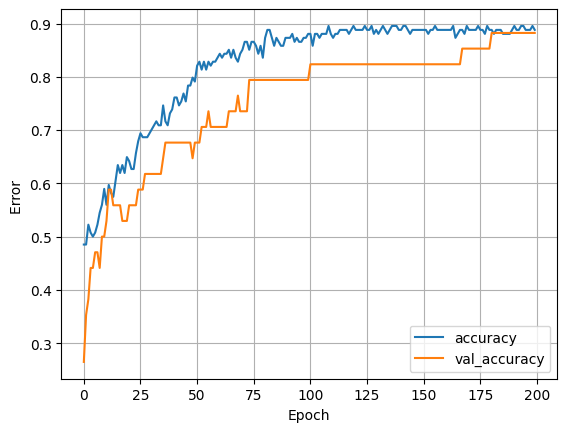

In [340]:
plot_loss(history)

In [298]:
y_pred = model.predict(X_test).flatten()
y_pred

2/2 [==============================] - 0s 4ms/step


array([0.08407813, 0.2356968 , 0.6088994 , 0.19334859, 0.12656665,
       0.13241577, 0.11309853, 0.06864251, 0.04553712, 0.24443324,
       0.1590251 , 0.00080499, 0.19560227, 0.17714517, 0.07206239,
       0.02148865, 0.20109785, 0.20109785, 0.58981246, 0.15143341,
       0.17714517, 0.48840067, 0.3007058 , 0.22883277, 0.4715961 ,
       0.05583776, 0.11970794, 0.04123323, 0.05629136, 0.27144408,
       0.17714517, 0.18483827, 0.11419819, 0.10945278, 0.03703903,
       0.5364023 , 0.1714196 , 0.07285069, 0.20109785, 0.08324376,
       0.2373726 , 0.04301443], dtype=float32)

In [231]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f'Model accuracy: {accuracy}')

2/2 - 0s - loss: 0.1561 - accuracy: 0.0000e+00 - 27ms/epoch - 13ms/step
Model accuracy: 0.0


In [341]:
from sklearn.metrics import precision_score, recall_score
y_pred_c = y_pred.round().astype(int)
precision = precision_score(y_test_new, y_pred_c)
recall = recall_score(y_test_new, y_pred_c)

loss, accuracy = model.evaluate(X_test, y_test_new)

print('Loss:', loss)
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
y_test_new.sum(), y_pred_c.sum()

2/2 [==============================] - 0s 5ms/step - loss: 0.4124 - accuracy: 0.8333
Loss: 0.41239693760871887
Accuracy: 0.8333333134651184
Precision: 0.0
Recall: 0.0


(5.0, 1)

In [ ]:

a = plt.axes(aspect='equal')
plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')